KNN으로 전처리->모델링->평가

In [349]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/raw/Customer_Churn_Dataset_knn.csv', index_col=0)

1. 원핫인코딩 후 logistic regression. y는 label-encoding

In [350]:
df_clone = df.copy(deep=False)

In [211]:
df_clone.shape

(7043, 23)

In [351]:
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)

column_names = ohe.get_feature_names_out()

le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape




((7043, 15291), (7043,))

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [353]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("model", LogisticRegression(random_state=0, C=1))
])

pipeline.fit(X_train, y_train)
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)


In [354]:

print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.9611288604898829
재현율: 0.8956521739130435
정밀도: 0.9550641940085592
F1 점수: 0.9244045564376941
Average Precision: 0.9811931594045092
ROC-AUC Score: 0.9913487900798424


In [355]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.865152590489709
재현율: 0.7085561497326203
정밀도: 0.7658959537572254
F1 점수: 0.7361111111111112
Average Precision: 0.7972447672545233
ROC-AUC Score: 0.9232090728254411


In [356]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty":['l2']
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__penalty': ['l2']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [219]:
gs.best_score_

np.float64(0.850192955997161)

In [ ]:
gs.best_params_

{'model__C': 1, 'model__penalty': 'l2'}

In [226]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,24.843291,1.133912,0.095537,0.013308,1.00,l2,"{'model__C': 1, 'model__penalty': 'l2'}",0.850248,0.863023,0.852273,0.835227,0.850193,0.009911,1
3,28.664420,0.325306,0.043751,0.019196,10.00,l2,"{'model__C': 10, 'model__penalty': 'l2'}",0.841732,0.862314,0.852273,0.835227,0.847886,0.010314,2
1,15.244092,0.370059,0.143451,0.016592,0.10,l2,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.845990,0.855926,0.849432,0.828835,0.845046,0.010016,3
0,12.025393,0.599676,0.243368,0.028443,0.01,l2,"{'model__C': 0.01, 'model__penalty': 'l2'}",0.830376,0.830376,0.843040,0.811080,0.828718,0.011421,4


In [222]:
pipeline['model'].coef_

array([[-0.03701481, -0.15224596,  0.25115281, ...,  2.52647559,
         1.46704302,  0.        ]], shape=(1, 15291))

In [359]:
# 회귀 계수 확인
coefficients = pipeline['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용

# 피처 이름과 계수 매핑
feature_names = column_names # 학습 시 사용한 피처 이름
coef_series = pd.Series(coefficients, index=feature_names)

# 결과 출력 (계수 값 기준 정렬 등)
print(coef_series.sort_values(ascending=False))

tenure_1            2.626562
numTechTickets_7    2.526476
tenure_2            1.886832
tenure_5            1.789600
numTechTickets_6    1.690296
                      ...   
numTechTickets_1   -1.423512
tenure_72          -1.429326
tenure_71          -1.455068
tenure_60          -1.471223
numTechTickets_0   -4.269046
Length: 15291, dtype: float64


In [248]:
df_clone

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,5,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,0,0,Yes


이 위까지 one-hot encoding 후 linear regression

2. Randomforest

In [265]:
df_clone = df.copy(deep=False)
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)
randomforest_feature_name = ohe.get_feature_names_out()
le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape


((7043, 15291), (7043,))

In [240]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7043, 15291))

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [249]:
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("model", RandomForestClassifier(max_depth=16, random_state=42) )
])
# 랜덤 포레스트 모델 생성 및 학습
pipeline.fit(X_train, y_train)


,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,16
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


In [ ]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)

In [251]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.7715654952076677
재현율: 0.14180602006688964
정밀도: 0.9814814814814815
F1 점수: 0.24780829924021042
Average Precision: 0.8280511180523574
ROC-AUC Score: 0.921969502917432


In [ ]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.7466288147622427
재현율: 0.05614973262032086
정밀도: 0.84
F1 점수: 0.10526315789473684
Average Precision: 0.6906237074337808
ROC-AUC Score: 0.8767599266320494


In [254]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__max_depth": [4, 8, 16, 32, 64],
    "model__n_estimators":[10, 50, 100, 200]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [4, 8, ...], 'model__n_estimators': [10, 50, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [255]:
print(gs.best_score_)
print(gs.best_params_)

0.8333345094844828
{'model__max_depth': 64, 'model__n_estimators': 200}


In [257]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
19,88.394009,4.938513,0.199254,0.027301,64,200,"{'model__max_depth': 64, 'model__n_estimators'...",0.831796,0.828247,0.845881,0.827415,0.833335,0.007428,1
18,68.466281,11.285543,0.547727,0.171147,64,100,"{'model__max_depth': 64, 'model__n_estimators'...",0.828247,0.825408,0.844460,0.833097,0.832803,0.007270,2
17,32.026392,3.631150,0.276424,0.039853,64,50,"{'model__max_depth': 64, 'model__n_estimators'...",0.829666,0.825408,0.840199,0.828835,0.831027,0.005531,3
16,7.098862,0.725321,0.187541,0.022793,64,10,"{'model__max_depth': 64, 'model__n_estimators'...",0.806246,0.813343,0.823864,0.804688,0.812035,0.007569,4
15,106.247082,8.593611,0.425560,0.185424,32,200,"{'model__max_depth': 32, 'model__n_estimators'...",0.806955,0.800568,0.828125,0.807528,0.810794,0.010372,5
14,41.276463,7.181842,0.385439,0.017929,32,100,"{'model__max_depth': 32, 'model__n_estimators'...",0.811214,0.799148,0.825284,0.806818,0.810616,0.009506,6
13,21.944079,1.349939,0.276869,0.028323,32,50,"{'model__max_depth': 32, 'model__n_estimators'...",0.807665,0.801278,0.823864,0.806818,0.809906,0.008424,7
12,6.220970,0.395718,0.244207,0.020391,32,10,"{'model__max_depth': 32, 'model__n_estimators'...",0.804826,0.815472,0.811080,0.799716,0.807773,0.005996,8
8,3.666624,0.698063,0.181113,0.018269,16,10,"{'model__max_depth': 16, 'model__n_estimators'...",0.788502,0.773598,0.767756,0.764915,0.773693,0.009105,9
9,12.206618,2.702859,0.277572,0.024975,16,50,"{'model__max_depth': 16, 'model__n_estimators'...",0.753016,0.751597,0.753551,0.747869,0.751508,0.002219,10


베스트 파라미터로 다시 수정

In [259]:
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
pipeline = Pipeline([
    ("model", RandomForestClassifier(max_depth=64, n_estimators=200, random_state=42) )
])
# 랜덤 포레스트 모델 생성 및 학습
pipeline.fit(X_train, y_train)

# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)

In [260]:
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.9964501242456514
재현율: 0.991304347826087
정밀도: 0.9952988582941572
F1 점수: 0.9932975871313673
Average Precision: 0.9998398976534038
ROC-AUC Score: 0.9999419826578245


In [261]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8261178140525195
재현율: 0.4946524064171123
정밀도: 0.7676348547717843
F1 점수: 0.6016260162601627
Average Precision: 0.7286737098449158
ROC-AUC Score: 0.8971970342814333


In [264]:
pipeline['model'].feature_importances_

array([7.47917448e-06, 1.61320432e-05, 3.92531715e-05, ...,
       3.91926570e-03, 9.49250092e-04, 0.00000000e+00], shape=(15291,))

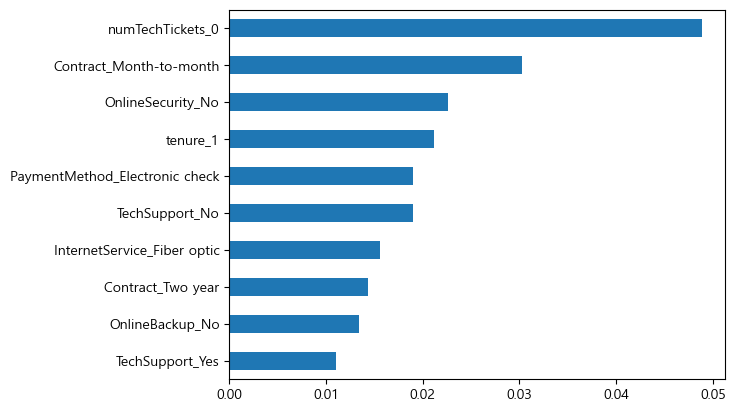

In [281]:
randomforest_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=randomforest_feature_name).sort_values(ascending=False)
fi
fi[:10].sort_values().plot(kind="barh");


여기까지 원핫인코딩 후 randomforest. y는 label

3. decision tree

In [283]:
df_clone = df.copy(deep=False)
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)
decision_feature_name = ohe.get_feature_names_out()
le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape


((7043, 15291), (7043,))

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [286]:
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ("model", DecisionTreeClassifier(max_depth=8, random_state=42) )
])
# 디시전 트리 모델 생성 및 학습
pipeline.fit(X_train, y_train)

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None


In [287]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)

In [288]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8659921902733404
재현율: 0.7311036789297659
정밀도: 0.7558782849239281
F1 점수: 0.7432845970758245
Average Precision: 0.8178847023102949
ROC-AUC Score: 0.9252507149142546


In [289]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8317955997161107
재현율: 0.6871657754010695
정밀도: 0.6816976127320955
F1 점수: 0.6844207723035952
Average Precision: 0.7063271094926493
ROC-AUC Score: 0.8627890154744375


In [291]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__max_depth": [4, 8, 16, 32, 64]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [4, 8, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [292]:
print(gs.best_score_)
print(gs.best_params_)

0.8290742799938706
{'model__max_depth': 8}


In [293]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
1,11.621430,0.807434,0.193621,0.057236,8,{'model__max_depth': 8},0.818311,0.835344,0.840909,0.821733,0.829074,0.009342,1
2,11.680907,0.941044,0.150106,0.025381,16,{'model__max_depth': 16},0.821859,0.831796,0.830966,0.828125,0.828186,0.003898,2
4,7.561736,1.085423,0.040658,0.009928,64,{'model__max_depth': 64},0.828957,0.834634,0.825284,0.821023,0.827475,0.004997,3
3,13.886316,0.645483,0.092865,0.029286,32,{'model__max_depth': 32},0.833925,0.834634,0.827415,0.811080,0.826763,0.009482,4
0,10.006340,1.417477,0.177104,0.006413,4,{'model__max_depth': 4},0.830376,0.823989,0.834517,0.817472,0.826588,0.006463,5


In [294]:
pipeline['model'].feature_importances_

array([0.        , 0.        , 0.        , ..., 0.00652049, 0.00263925,
       0.        ], shape=(15291,))

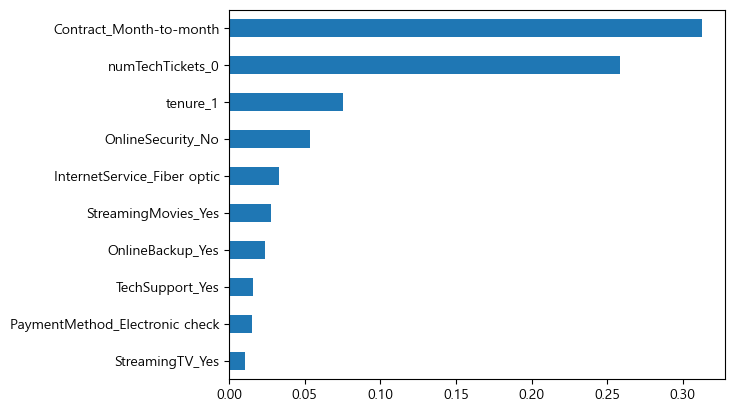

In [295]:
decision_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=decision_feature_name).sort_values(ascending=False)
fi
fi[:10].sort_values().plot(kind="barh");

4. SVM

In [296]:
df = pd.read_csv('../data/raw/Customer_Churn_Dataset_knn.csv', index_col=0)
df_clone = df.copy(deep=False)
df_clone = df_clone.drop(columns=["Churn"])
numeric_cols = df_clone.select_dtypes(include=['int64','float64']).columns
categorical_cols = df_clone.select_dtypes(include=['object']).columns

In [297]:
df_clone

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,5
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,0,0


In [94]:
df_clone[categorical_cols]

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,2234-XADUH,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,4801-JZAZL,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,8361-LTMKD,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


In [298]:
le = LabelEncoder()
# y = df_clone['Churn']
for i in categorical_cols:
    df_clone[i] = le.fit_transform(df_clone[i])

In [299]:
df_clone[categorical_cols]

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,5375,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2
1,3962,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3
2,2564,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3
3,5535,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0
4,6511,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4853,1,1,1,1,2,0,2,0,2,2,2,2,1,1,3
7039,1525,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1
7040,3367,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2
7041,5934,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3


In [300]:
df_clone[categorical_cols].values

array([[5375,    0,    1, ...,    0,    1,    2],
       [3962,    1,    0, ...,    1,    0,    3],
       [2564,    1,    0, ...,    0,    1,    3],
       ...,
       [3367,    0,    1, ...,    0,    1,    2],
       [5934,    1,    1, ...,    0,    1,    3],
       [2226,    1,    0, ...,    2,    1,    0]], shape=(7043, 16))

In [367]:
# type(cate_features)
# one hot encoding한 범주형 feature들과 수치형 feature들을 합치기.
X = np.concatenate(
    [df_clone[categorical_cols].values, df_clone[numeric_cols].values], 
    axis=1
)
X.shape

(7043, 22)

In [329]:
print(len(categorical_cols))
print(len(numeric_cols))

16
6


In [47]:
df_clone[numeric_cols]

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,0,1,29.85,29.85,0,0
1,0,34,56.95,1889.50,0,0
2,0,2,53.85,108.15,0,0
3,0,45,42.30,1840.75,0,3
4,0,2,70.70,151.65,0,0
...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,0
7039,0,72,103.20,7362.90,0,5
7040,0,11,29.60,346.45,0,0
7041,1,4,74.40,306.60,0,0


In [303]:
le = LabelEncoder()
# y = df_clone['Churn']
y = le.fit_transform(df['Churn'])
# y = df_clone['Churn']
X.shape, y.shape

((7043, 22), (7043,))

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [305]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ("scaler", StandardScaler()), ("model", SVC(
        kernel="linear", # 커널 함수 지정. 선형SVM: linear, 비선형SVM: rbf(기본), poly, sigmoid
        C=1,             # soft - hard margin 설정. (작을수록 강한 규제)
        random_state=0
    ))
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'


In [307]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.8564075257365992
0.8566359119943222


In [309]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__gamma" : [0.001, 0.01, 0.1, 1, 5, 10, 100]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.001, 0.01, ...], 'model__gamma': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [310]:
print(gs.best_score_)
print(gs.best_params_)

0.8533883486434609
{'model__C': 1, 'model__gamma': 0.001}


In [311]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
24,0.663449,0.052097,0.067648,0.005504,1.000,1.000,"{'model__C': 1, 'model__gamma': 1}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
25,0.555979,0.019195,0.062641,0.006441,1.000,5.000,"{'model__C': 1, 'model__gamma': 5}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
26,0.629017,0.061147,0.059561,0.005066,1.000,10.000,"{'model__C': 1, 'model__gamma': 10}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
27,0.564947,0.046179,0.065008,0.008756,1.000,100.000,"{'model__C': 1, 'model__gamma': 100}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
23,0.626041,0.070434,0.061982,0.011540,1.000,0.100,"{'model__C': 1, 'model__gamma': 0.1}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
21,0.592002,0.053936,0.057776,0.009679,1.000,0.001,"{'model__C': 1, 'model__gamma': 0.001}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
22,0.655075,0.054901,0.067066,0.005819,1.000,0.010,"{'model__C': 1, 'model__gamma': 0.01}",0.854507,0.862314,0.855824,0.840909,0.853388,0.007787,1
28,2.157419,0.041253,0.060830,0.005131,10.000,0.001,"{'model__C': 10, 'model__gamma': 0.001}",0.852378,0.862314,0.855114,0.840909,0.852678,0.007704,8
29,2.077227,0.078682,0.063666,0.010961,10.000,0.010,"{'model__C': 10, 'model__gamma': 0.01}",0.852378,0.862314,0.855114,0.840909,0.852678,0.007704,8
31,2.244225,0.127139,0.064358,0.005880,10.000,1.000,"{'model__C': 10, 'model__gamma': 1}",0.852378,0.862314,0.855114,0.840909,0.852678,0.007704,8


최적 파라미터로 다시 학습

In [312]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ("scaler", StandardScaler()), ("model", SVC(
        kernel="linear", # 커널 함수 지정. 선형SVM: linear, 비선형SVM: rbf(기본), poly, sigmoid
        C=1,             # soft - hard margin 설정. (작을수록 강한 규제)
        gamma=0.001,
        random_state=0
    ))
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'linear'
,degree,3
,gamma,0.001


In [313]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.8564075257365992
0.8566359119943222


In [325]:
len(a)

16

In [341]:
# 회귀 계수 확인
coefficients = pipeline['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용

# 피처 이름과 계수 매핑

feature_names = a # 학습 시 사용한 피처 이름
coef_series = pd.Series(coefficients, index=feature_names)

# 결과 출력 (계수 값 기준 정렬 등)
print(coef_series.sort_values(ascending=False))

ValueError: Length of values (22) does not match length of index (1)

In [322]:
a[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=a).sort_values(ascending=False)
fi
fi[:10].sort_values().plot(kind="barh");

AttributeError: 'SVC' object has no attribute 'feature_importances_'

--------------------------

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
# SVR: 회귀, SVC: 분류
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Linear SVM - 규제 hyper parameter: C
## 작을 수록 규제 강도가 큼.
C_list = [0.001, 0.01, 0.1, 1, 10, 100] # 0 초과의 값을 지정. 실수. default: 1
train_acc_list = []
test_acc_list = []

for C in C_list:
    svm = SVC(
        kernel="linear", # 커널 함수 지정. 선형SVM: linear, 비선형SVM: rbf(기본), poly, sigmoid
        C=C,             # soft - hard margin 설정. (작을수록 강한 규제)
        random_state=0
    )
    # 학습
    svm.fit(X_train_scaled, y_train)
    # 검증
    ## 추론
    pred_train = svm.predict(X_train_scaled)
    pred_test = svm.predict(X_test_scaled)
    ## 평가
    train_acc_list.append(accuracy_score(y_train, pred_train))
    test_acc_list.append(accuracy_score(y_test, pred_test))

In [105]:
import pandas as pd
import numpy as np
#C값이 초반에 너무 천천히 변화해서 그래프가 요상하게 나오므로 변화율을 보기 위해 로그를 씌움
df = pd.DataFrame({
    "C":np.log10(C_list),
    # "C": C_list,
    "Train": train_acc_list,
    "Test": test_acc_list
})
df.set_index("C")

,Train,Test
C,,
-3.0,0.829606,0.819730
-2.0,0.854633,0.855926
-1.0,0.856053,0.856636
0.0,0.856408,0.856636
1.0,0.856585,0.856636
2.0,0.856763,0.856636


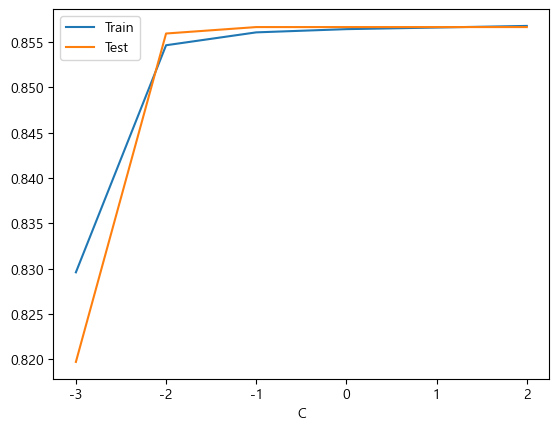

In [106]:
df.set_index("C").plot();

In [107]:
###############################################################################
# 비선형 SVM. Hyper Parameter - C: soft/hard margin 규제, gamma (기본: 1)
#
# gamma  변경에 따른 성능 변화.
###############################################################################
gamma_list = [0.001, 0.01, 0.1, 1, 5, 10, 100]
train_acc_list = []
test_acc_list = []
# 원래는 감마값만 바꾸는게 아니고 C값도 바꿔서 튜닝해야 함.
for gamma in gamma_list:
    svm = SVC(kernel="rbf", C=1, gamma=gamma)  # kernel기본값: rbf
    svm.fit(X_train_scaled, y_train)
    train_acc_list.append(accuracy_score(y_train, svm.predict(X_train_scaled)))
    test_acc_list.append(accuracy_score(y_test, svm.predict(X_test_scaled)))

In [108]:
df = pd.DataFrame({
    "gamma":np.log10(gamma_list),
    "Train":train_acc_list,
    "Test":test_acc_list
})
df #test가 뚝 떨어짐. train은 1.00이라 overfitting이라고 보면 됨.   

,gamma,Train,Test
0,-3.00000,0.850728,0.849539
1,-2.00000,0.859780,0.856636
2,-1.00000,0.913738,0.843861
3,0.00000,0.976748,0.750177
4,0.69897,0.987753,0.740241
5,1.00000,0.990238,0.738822
6,2.00000,0.996628,0.735273


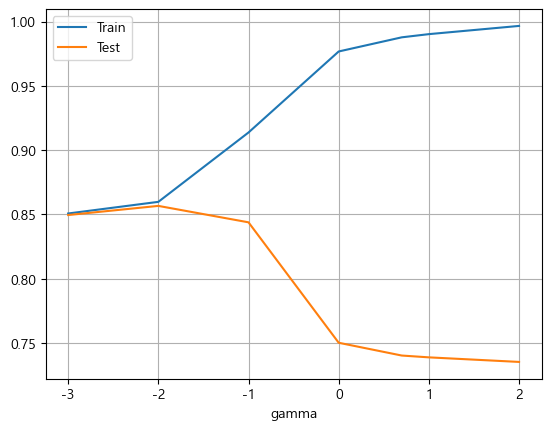

In [109]:
df.set_index("gamma").plot(grid=True);